## Creating a VQ sequence using Kmeans++

Remember to disable Cron so that Controller does not interfere.

In [1]:
import pickle as pk
import numpy as np
from glob import glob
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append('../scripts/lib/')

In [3]:
from shape_utils import *

In [4]:
import os 
os.environ

environ{'TERM_PROGRAM_VERSION': '421.1.1',
        'DATA_ROOTDIR': '/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/',
        'LOGNAME': 'kuiqian',
        'USER': 'kuiqian',
        'HOME': '/Users/kuiqian',
        'THUMBNAIL_DATA_ROOTDIR': '/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/',
        'PS1': '(shapeology_venv) \\h:\\W \\u\\$ ',
        'TERM_PROGRAM': 'Apple_Terminal',
        'LANG': 'en_US.UTF-8',
        'REPO_DIR': '/Users/kuiqian/Github/shapeology_code/scripts/',
        'TERM': 'xterm-color',
        'Apple_PubSub_Socket_Render': '/private/tmp/com.apple.launchd.36GMcxLPBc/Render',
        'ROOT_DIR': '/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/',
        'SHLVL': '1',
        'SECURITYSESSIONID': '186a7',
        'XPC_FLAGS': '0x0',
        'TMPDIR': '/var/folders/hg/9h6hnxt92px1fmpw4rzv259c0000gn/T/',
        'TERM_SESSION_ID': '8CC41745-C0A2-4EC9-8FA1-45D1DBD58C37',
        'XPC_SERVICE_NAME': '0',
        'JPY_PARENT_PID': '8658',
        'SSH_AUTH_SOCK': '

In [5]:
_size=81
data_dir=os.environ['ROOT_DIR']+'permuted'
data_dir

'/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/permuted'

### Load patches of chosend size
Each of the files below is a randomly permuted set of patches. The patches in each file are of a range of 
sizes. Defined by the size of the containing square. Thus `permuted-51.tgz` contains patches whose original square size is in the range (15,51]

In [6]:
!aws s3 ls s3://mousebraindata-open/MD657/permuted/

2019-01-04 15:35:42   67628479 permuted-15.tgz
2019-01-04 15:43:04  435151643 permuted-151.tgz
2019-01-04 15:43:34   67918044 permuted-201.tgz
2019-01-04 15:36:55  316654407 permuted-27.tgz
2019-01-04 15:39:24  909539046 permuted-51.tgz
2019-01-04 15:41:29  776408595 permuted-81.tgz


In [7]:
tgz_name = 'permuted-%d.tgz'%_size
dir_name = "/permuted-%d"%_size
patch_dir = data_dir+dir_name

In [14]:
!aws s3 cp s3://mousebraindata-open/MD657/permuted/$tgz_name $data_dir/$tgz_name

download: s3://mousebraindata-open/MD657/permuted/permuted-81.tgz to ../../../BstemAtlasDataBackup/ucsd_brain/permuted/permuted-81.tgz


In [18]:
!tar xzf $data_dir/$tgz_name -C $data_dir

In [19]:
!mv $data_dir/dev/shm/data/$dir_name $data_dir

In [8]:
!ls -lh $patch_dir | head
!du -sh $patch_dir

total 12812336
-rw-r--r--  1 kuiqian  staff    63M Jan  4 15:40 permuted0.bin
-rw-r--r--  1 kuiqian  staff    63M Jan  4 15:40 permuted1.bin
-rw-r--r--  1 kuiqian  staff    63M Jan  4 15:40 permuted10.bin
-rw-r--r--  1 kuiqian  staff    62M Jan  4 15:40 permuted11.bin
-rw-r--r--  1 kuiqian  staff    63M Jan  4 15:40 permuted12.bin
-rw-r--r--  1 kuiqian  staff    63M Jan  4 15:40 permuted13.bin
-rw-r--r--  1 kuiqian  staff    63M Jan  4 15:40 permuted14.bin
-rw-r--r--  1 kuiqian  staff    61M Jan  4 15:40 permuted15.bin
-rw-r--r--  1 kuiqian  staff    61M Jan  4 15:40 permuted16.bin
6.1G	/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/permuted/permuted-81


In [186]:
from os import system
def run(cmd):
    print('cmd=',cmd)
    system(cmd)

In [187]:
run('touch tmp')
!ls -l tmp

cmd= touch tmp
-rw-rw-r-- 1 ubuntu ubuntu 0 Jan  8 23:19 tmp


In [9]:
def read_files():
    for filename in glob(patch_dir+'/*.bin'):
        D=fromfile(filename,dtype=np.float16)
        print('in read_files filename=%s, shape='%filename,D.shape)
        pics=D.reshape([-1,_size,_size])
        #!rm $data_dir/$filename
        yield pics

In [10]:
def data_stream():
    for pics in read_files():
        for i in range(pics.shape[0]):
            yield pics[i,:,:]

### read 500,000 patches into memory

There are many millions of patches, but we don't need as many to compute the k-means and the diffusion map.

In [11]:
pics_list=[]
i=0
for pic in data_stream():
    pics_list.append(np.array(pic,dtype=np.float32))
    i+=1
    if i>=500000:
        break

    
    

in read_files filename=/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/permuted/permuted-81/permuted72.bin, shape= (32969025,)
in read_files filename=/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/permuted/permuted-81/permuted66.bin, shape= (33913809,)
in read_files filename=/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/permuted/permuted-81/permuted99.bin, shape= (32791878,)
in read_files filename=/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/permuted/permuted-81/permuted98.bin, shape= (32640975,)
in read_files filename=/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/permuted/permuted-81/permuted67.bin, shape= (33244587,)
in read_files filename=/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/permuted/permuted-81/permuted73.bin, shape= (32247315,)
in read_files filename=/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/permuted/permuted-81/permuted65.bin, shape= (33848199,)
in read_files filename=/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/permuted/permuted-81/permuted71.bin, shape= (326

in read_files filename=/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/permuted/permuted-81/permuted90.bin, shape= (32798439,)
in read_files filename=/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/permuted/permuted-81/permuted84.bin, shape= (32962464,)
in read_files filename=/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/permuted/permuted-81/permuted85.bin, shape= (32936220,)
in read_files filename=/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/permuted/permuted-81/permuted91.bin, shape= (32437584,)
in read_files filename=/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/permuted/permuted-81/permuted46.bin, shape= (32411340,)
in read_files filename=/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/permuted/permuted-81/permuted52.bin, shape= (32929659,)
in read_files filename=/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/permuted/permuted-81/permuted44.bin, shape= (33014952,)
in read_files filename=/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/permuted/permuted-81/permuted50.bin, shape= (324

In [12]:
len(pics_list)

499902

### Show a sample of the patches

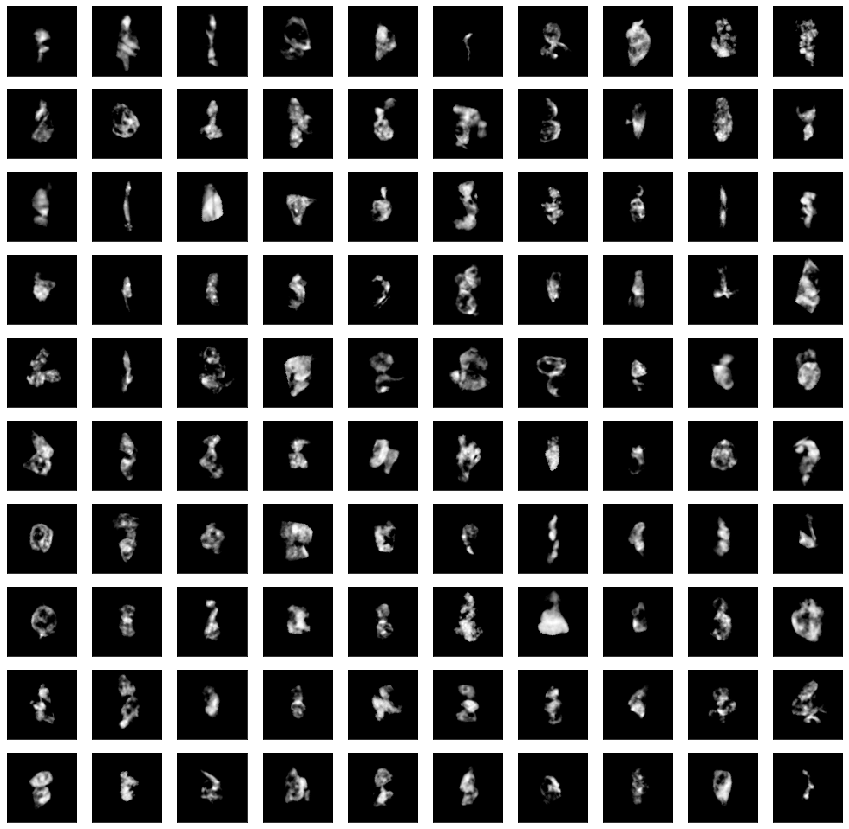

In [13]:
pics=pack_pics(pics_list)
fig=figure(figsize=(15,15))
plot_patches(fig,pics,h=10,w=10)

### Compute the distrbution of the distances between patches.

In [14]:
def dist2(a,b):
    diff=(a-b)**2
    return sum(diff.flatten())

In [15]:
D=[]
for i in range(1,pics.shape[0]):
    D.append(dist2(pics[i,:,:],pics[i-1,:,:]))
    if i%1000==0:
        print('\r',i,end='')

 499000

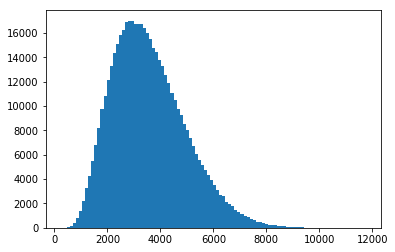

In [16]:
hist(D,bins=100);

In [23]:
min(D)

247.38117680734376

In [18]:
def refineKmeans(data,Reps):
    new_Reps=[np.zeros(Reps[0].shape) for r in Reps]
    Reps_count=[0.0 for r in Reps]
    error=0
    for i in range(data.shape[0]): 
        patch=data[i,:,:]
        dists=[dist2(patch,r) for r in Reps]
        _argmin=argmin(dists)
        _min=min(dists)
        new_Reps[_argmin]+=patch
        Reps_count[_argmin]+=1
        error+=_min
    error /= data.shape[0]
    final_Reps=[]
    final_counts=[]
    for i in range(len(new_Reps)):
        if Reps_count[i]>5:
            final_Reps.append(new_Reps[i]/Reps_count[i])
            final_counts.append(Reps_count[i])
    return final_Reps,final_counts,error

In [19]:
def Kmeans(data,n=100,scale=550):
    Reps,Statistics = Kmeanspp(data,n,scale)
    for i in range(5):
        Reps,error = refineKmeans(data,Reps)
        print('refine iteration %2d, error=%7.3f'%(i,error))

In [20]:
def Kmeanspp(data,n=100,scale=550):
    Reps=[data[0,:,:]]

    Statistics=[]
    j=1
    mean_prob=1
    alpha=0.01
    for i in range(1,data.shape[0]): 
        _min=100000
        patch=data[i,:,:]
        for r in Reps:
            _min=min(_min,dist2(patch,r))
        Prob=_min/scale
        print('\r','i=%10d,  #reps=%10d  Prob=%8.6f,scale=%8.4f'%(i,len(Reps),Prob,scale),end='')
        Statistics.append((i,len(Reps),_min))
        if np.random.rand()<Prob:
            Reps.append(patch)
            j+=1
        if j>=n:
            break
        if Prob>0.5:
            scale=scale*2
        else:
            scale=scale-1
    return Reps,Statistics

In [21]:
def plot_statistics(Statistics,alpha=0.05,_start=10): 
    N=[x[1] for x in Statistics]
    d=[x[2] for x in Statistics]

    s=mean(d[:_start])
    smoothed=[s]*_start
    for x in d[_start:]:
        s=(1-alpha)*s + alpha*x
        smoothed.append(s)
    loglog(N[_start:],smoothed[_start:])
    xlabel('N')
    ylabel('smoothed distance')
    grid(which='both')

### Run Kmeans++ to generate a given number of samples

In [22]:
N=2000

Reps, Statistics = Kmeanspp(pics,n=N,scale=3000)
Reps_mat = pack_pics(Reps)

 i=       210,  #reps=        34  Prob=0.213605,scale=11793.0000

 i=       350,  #reps=        52  Prob=0.134546,scale=11653.0000

 i=     20082,  #reps=      1999  Prob=0.270585,scale=11553.0000i=     11383,  #reps=      1312  Prob=0.060224,scale=20252.0000

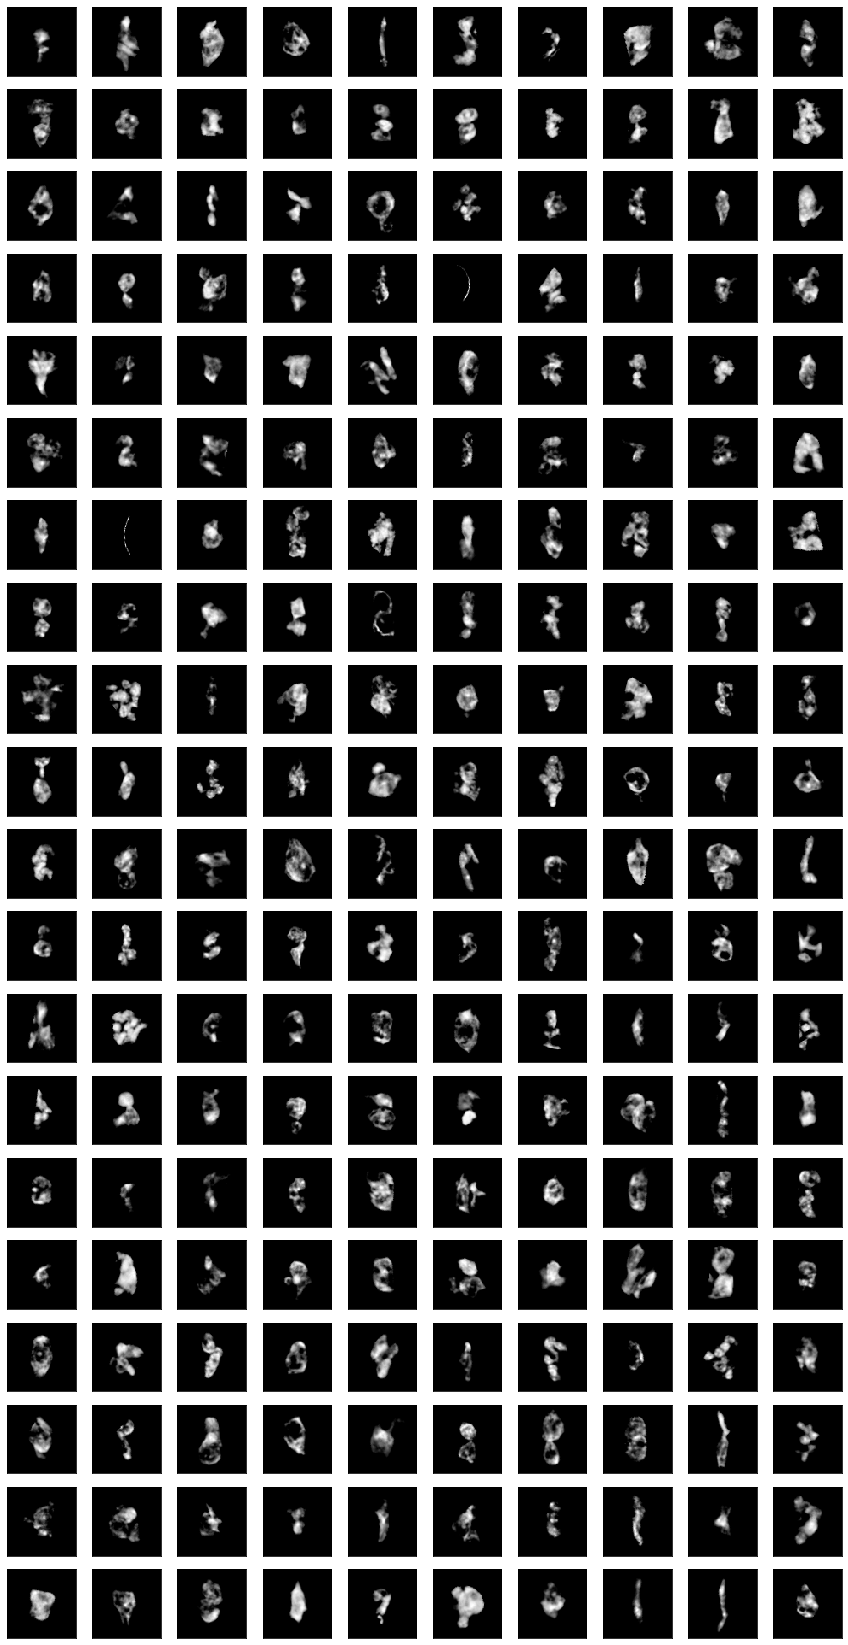

In [24]:
fig=figure(figsize=(15,30))
plot_patches(fig,Reps_mat,h=20,w=10)

In [25]:
Reps_mat.shape

(2000, 81, 81)

### Perform K-means refinement
of the representatives

3 1304.0832597485542 1084
4 1026.1214126508728 1062
5 1003.1592320703834 1055
6 996.3546607496033 1052


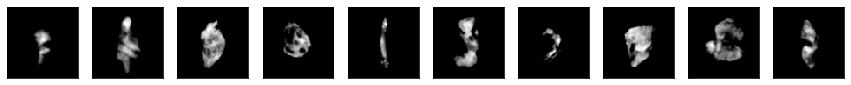

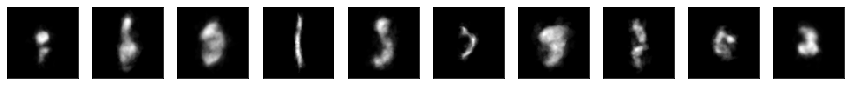

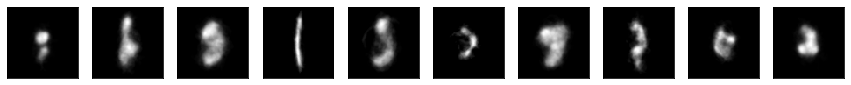

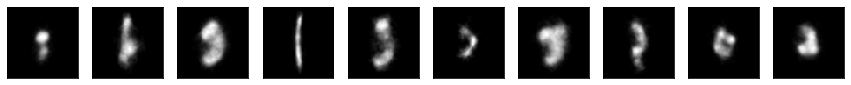

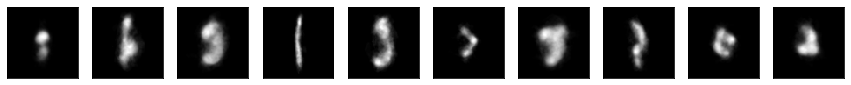

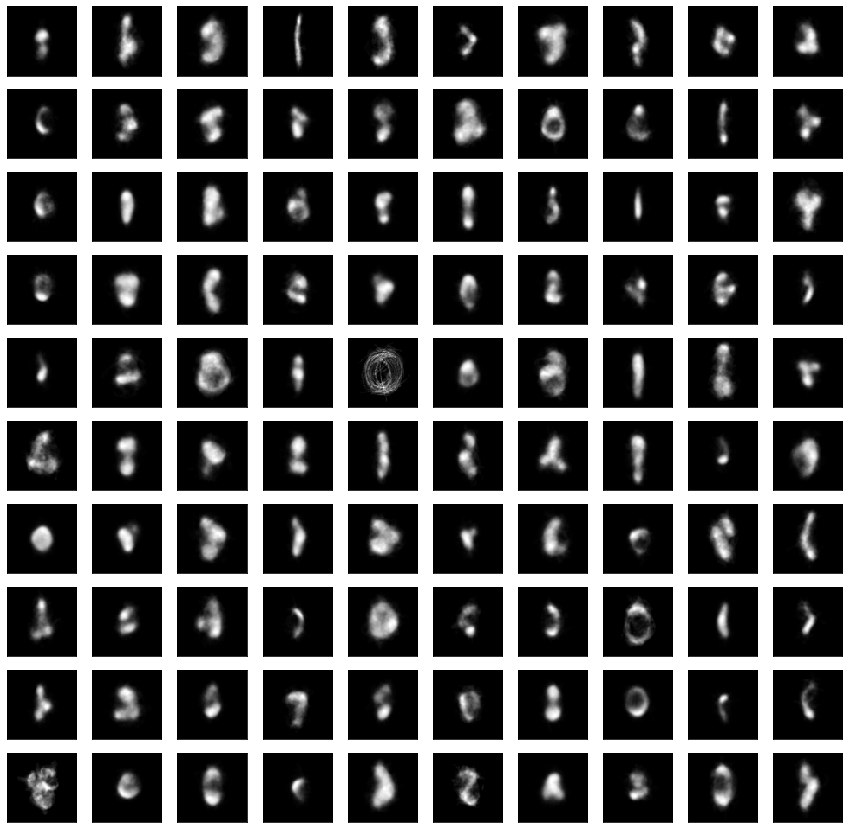

In [26]:
fig=figure(figsize=(15,1.5))
plot_patches(fig,Reps_mat,h=1,w=10) #,_titles=['%4d'%x for x in Reps_count])
for i in range(3,7):
    new_Reps,Reps_count,error = refineKmeans(pics[i*50000:(i+1)*50000,:,:],Reps)
    print(i,error,len(Reps_count))
    Reps_mat = pack_pics(new_Reps)
    fig=figure(figsize=(15,1.5))
    plot_patches(fig,Reps_mat,h=1,w=10) #,_titles=['%4d'%x for x in Reps_count])
    Reps=new_Reps
fig=figure(figsize=(15,15))
plot_patches(fig,Reps_mat,h=10,w=10) #,_titles=['final_%4d'%x for x in Reps_count])

## Calculate diffusion map

The matrix corresponds to a simple random walk on the individual examples  where the location of each example is replaced by the location of the corresponding representative. 

We use [pydiffmap](https://pydiffmap.readthedocs.io/en/master/)

In [27]:
L=len(new_Reps)
print(new_Reps[0].shape)
data1D=np.concatenate([x.reshape([1,_size*_size]) for x in new_Reps])
data1D.shape

(81, 81)


(1052, 6561)

Text(0.5, 1.0, 'distances between centroids')

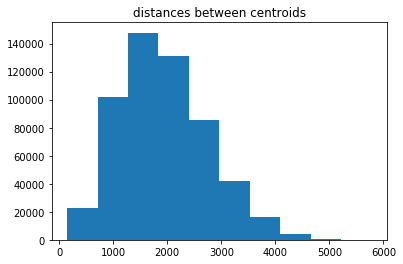

In [28]:
dists=[]
for i in range(L):
    for j in range(i):
        dists.append(dist2(new_Reps[i],new_Reps[j]))
hist(dists);
title('distances between centroids')

In [29]:
from pydiffmap import diffusion_map as dm
# initialize Diffusion map object.
neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}

mydmap = dm.DiffusionMap.from_sklearn(n_evecs=200, k=20, epsilon=300.0, alpha=1.0, neighbor_params=neighbor_params)
# fit to data and return the diffusion map.
dmap = mydmap.fit_transform(data1D)
dmap.shape

(1052, 200)

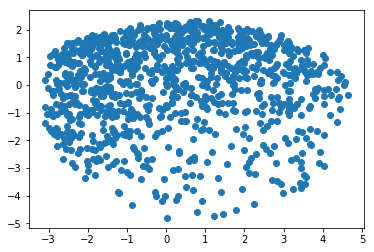

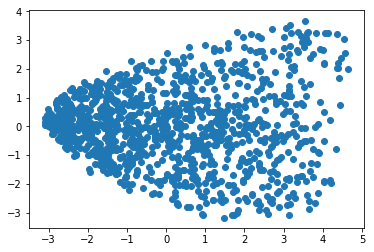

In [30]:
pylab.scatter(dmap[:,0],dmap[:,1]);
figure()
pylab.scatter(dmap[:,0],dmap[:,2]);

In [178]:
mydmap?

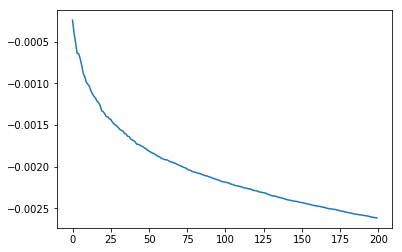

In [31]:
plot(mydmap.evals);

Text(0.5, 1.0, 'no. of examples per partition')

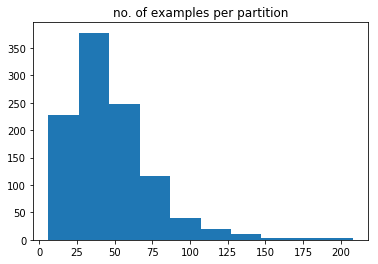

In [32]:
hist(Reps_count);
title('no. of examples per partition')

### Create Scatter Images

In [33]:
def scatter_images(pics,dmap,d1=0,d2=1,canvas_sz=1000):
    canvas_size=np.array([canvas_sz,canvas_sz])
    _minx=min(dmap[:,d1])
    _maxx=max(dmap[:,d1])
    _miny=min(dmap[:,d2])
    _maxy=max(dmap[:,d2])
    shift_x = -_minx
    scale_x = canvas_size[0]/(_maxx - _minx)
    shift_y = -_miny
    scale_y = canvas_size[1]/(_maxy - _miny)

    x=[int((_x+shift_x)*scale_x) for _x in dmap[:,d1]]
    y=[int((_y+shift_y)*scale_y) for _y in dmap[:,d2]]

    image_size=np.array(pics.shape[1:])
    canvas=2*np.ones(canvas_size+image_size)
    for i in range(pics.shape[0]):
        canvas[x[i]:x[i]+image_size[0],y[i]:y[i]+image_size[1]]=pics[i,:,:]
    return canvas

### Create a scatter-plot of the representative patches

In [36]:
from cv2 import imwrite

In [34]:
Rep_pics=pack_pics(new_Reps)

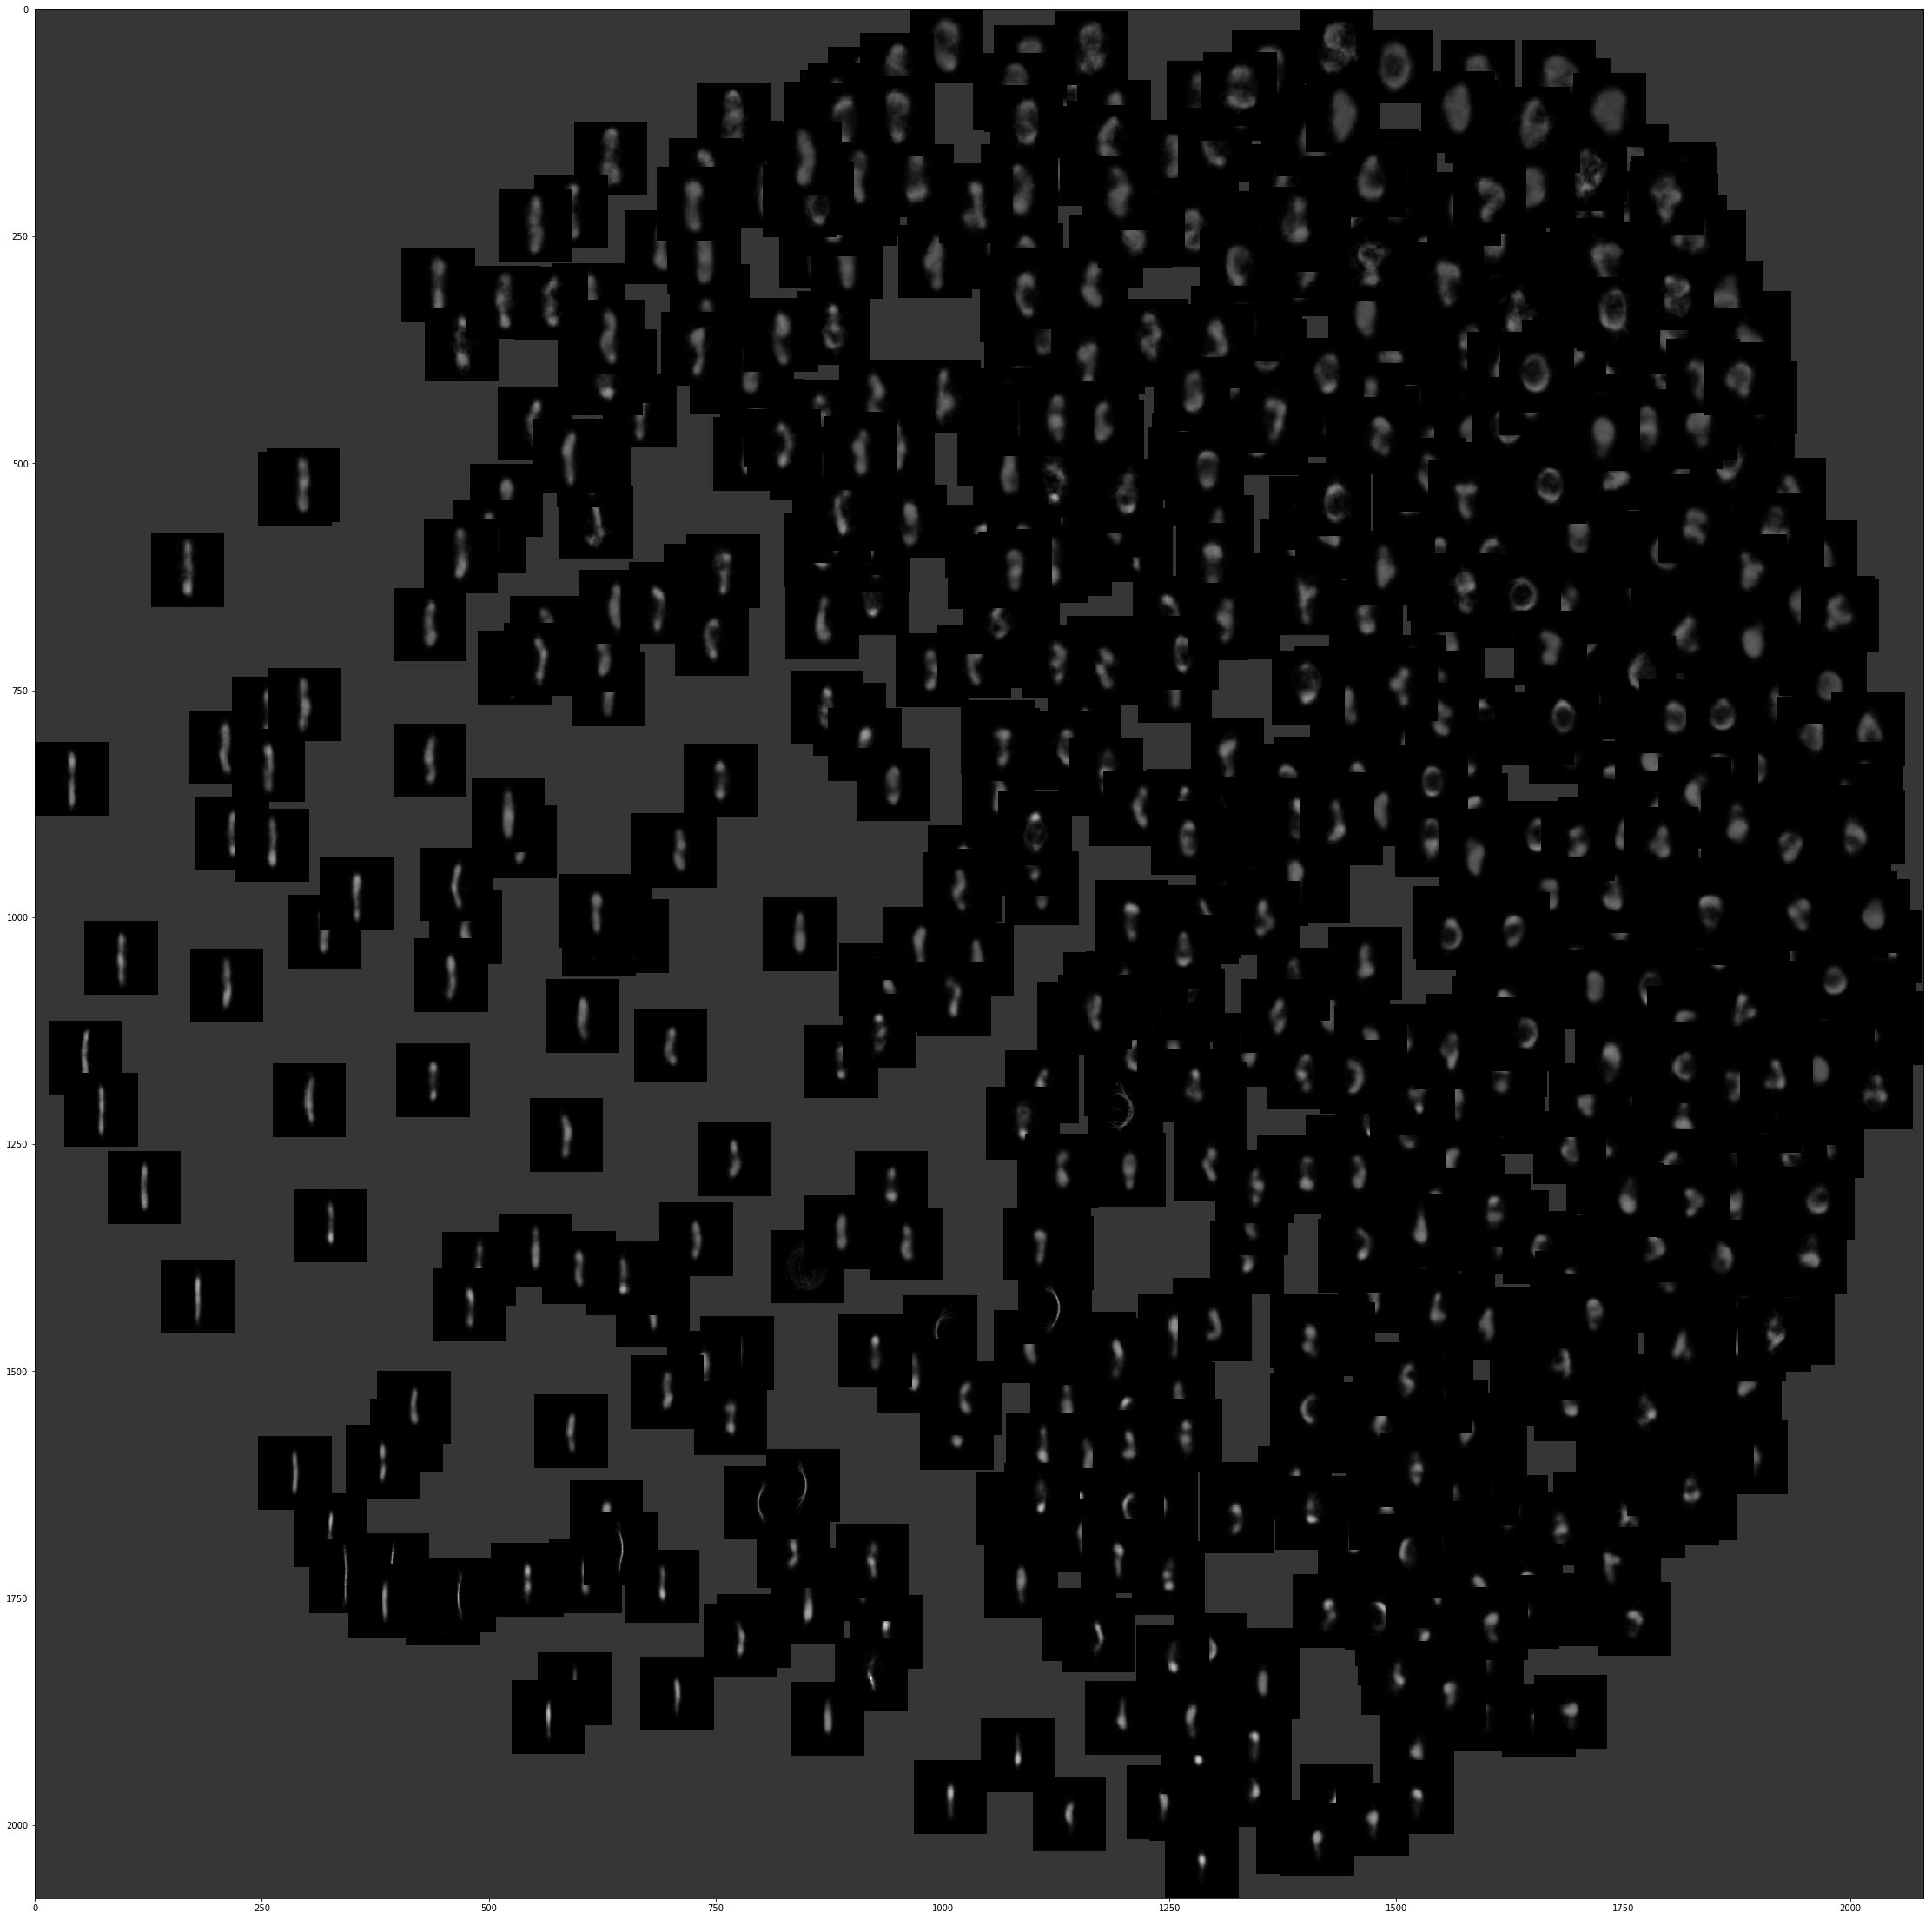

In [37]:
figure(figsize=[40,40])
canvas=scatter_images(Rep_pics,dmap,d1=0,d2=1,canvas_sz=2000)
imshow(canvas,cmap='gray');
imwrite('Reps01.tiff',canvas);

### Transform raw patches and create scatter plots for them

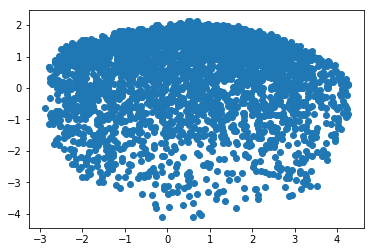

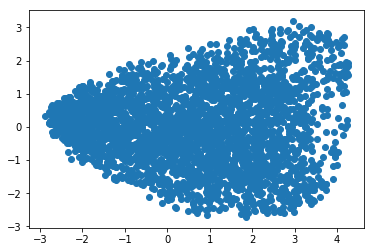

In [38]:
some_pics=pics[1000:4000,:,:]
data=some_pics.reshape([-1,_size*_size])
data.shape

dmap = mydmap.transform(data)

pylab.scatter(dmap[:,0],dmap[:,1]);
figure()
pylab.scatter(dmap[:,0],dmap[:,2]);

In [39]:
dmap.shape

(3000, 200)

In [228]:
!mv scatterplots/ scatterplots-51/

In [230]:
!rm -rf scatterplots
!mkdir scatterplots-27

In [231]:
for d1 in range(5):
    for d2 in range(d1+1,8):
        #print(d1,d2)
        canvas=scatter_images(some_pics,dmap,d1,d2,canvas_sz=10000)
        imwrite('scatterplots-27/scatter%d%d.tiff'%(d1,d2),canvas);

In [232]:
!aws s3 cp --recursive scatterplots-27/ s3://mousebraindata-open/MD657/scatterplots-27/

upload: scatterplots-27/scatter13.tiff to s3://mousebraindata-open/MD657/scatterplots-27/scatter13.tiff
upload: scatterplots-27/scatter07.tiff to s3://mousebraindata-open/MD657/scatterplots-27/scatter07.tiff
upload: scatterplots-27/scatter01.tiff to s3://mousebraindata-open/MD657/scatterplots-27/scatter01.tiff
upload: scatterplots-27/scatter03.tiff to s3://mousebraindata-open/MD657/scatterplots-27/scatter03.tiff
upload: scatterplots-27/scatter06.tiff to s3://mousebraindata-open/MD657/scatterplots-27/scatter06.tiff
upload: scatterplots-27/scatter14.tiff to s3://mousebraindata-open/MD657/scatterplots-27/scatter14.tiff
upload: scatterplots-27/scatter12.tiff to s3://mousebraindata-open/MD657/scatterplots-27/scatter12.tiff
upload: scatterplots-27/scatter04.tiff to s3://mousebraindata-open/MD657/scatterplots-27/scatter04.tiff
upload: scatterplots-27/scatter02.tiff to s3://mousebraindata-open/MD657/scatterplots-27/scatter02.tiff
upload: scatterplots-27/scatter05.tiff to s3://mousebraindata-op

In [152]:
im=imread('scatterplots/scatter12.tiff')
im.shape

/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2546: DecompressionBombWarning: Image size (101022601 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


(10051, 10051)

In [153]:
type(im[0,0])

numpy.uint8

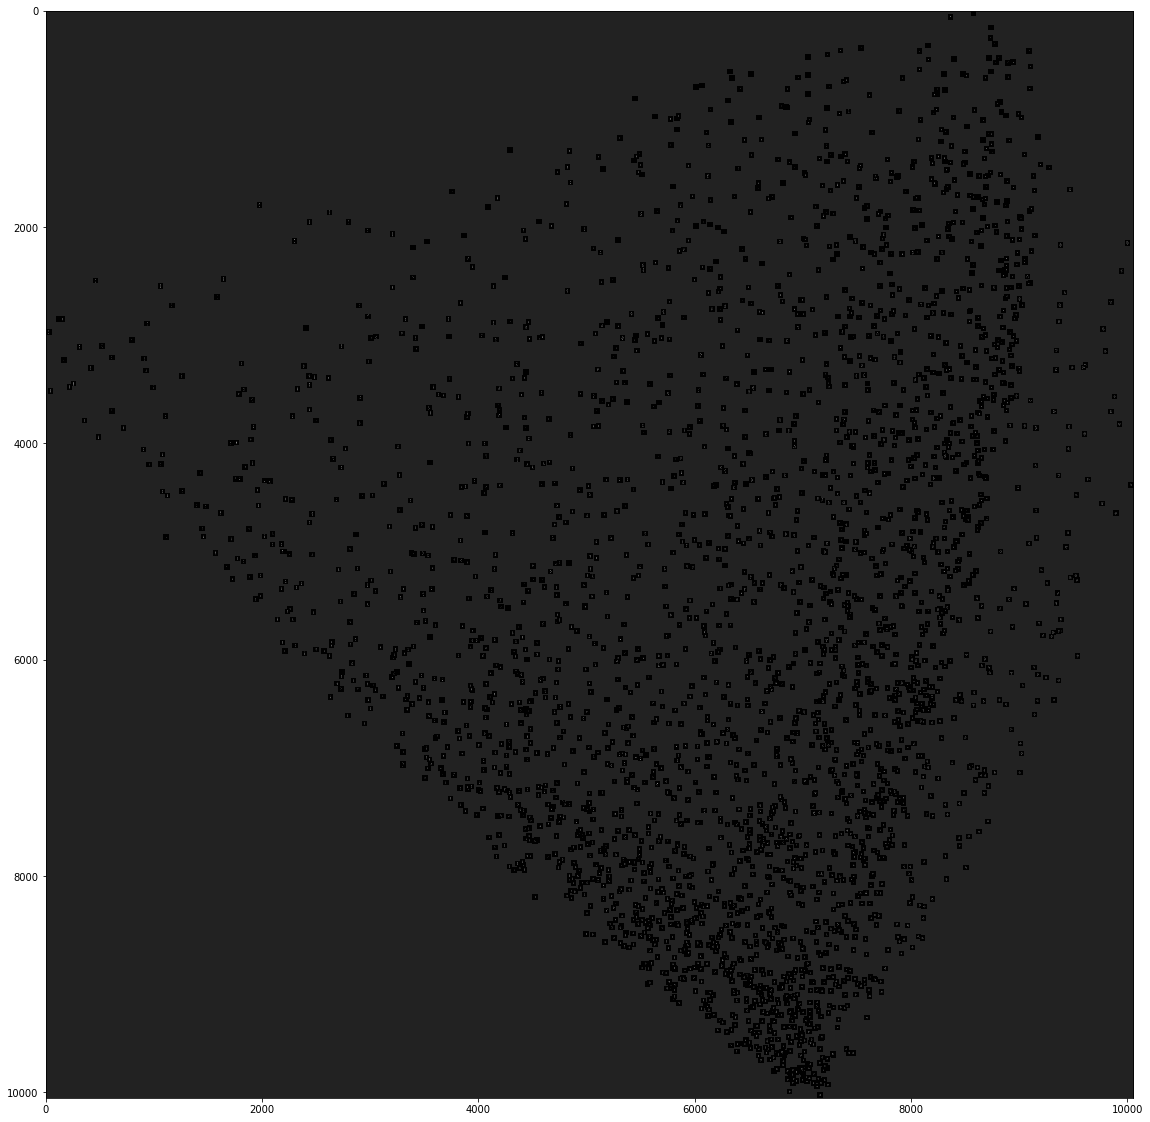

In [154]:
figure(figsize=(20,20))
imshow(im,cmap='gray');

In [119]:
!ls -lh scatterplots/

rm: cannot remove 'scatter??.*': No such file or directory
total 62M
-rw-rw-r-- 1 ubuntu ubuntu 2.4M Jan  4 02:19 scatter01.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.5M Jan  4 02:19 scatter02.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.5M Jan  4 02:19 scatter03.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.5M Jan  4 02:19 scatter04.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.6M Jan  4 02:19 scatter05.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.5M Jan  4 02:19 scatter06.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.5M Jan  4 02:19 scatter07.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.5M Jan  4 02:19 scatter12.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.5M Jan  4 02:19 scatter13.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.6M Jan  4 02:19 scatter14.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.6M Jan  4 02:19 scatter15.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.6M Jan  4 02:19 scatter16.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.6M Jan  4 02:19 scatter17.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.5M Jan  4 02:19 scatter23.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.5M Jan  4 02:19 scatter24.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.5M

### Save diffusion map as a pickle file

In [40]:
import dill
pkl_name = 'diffusionMap-%d.pkl'%_size
dill.dump(mydmap,open(pkl_name,'wb'))

In [41]:
!ls -lh *.pkl

-rw-r--r--  1 kuiqian  staff   7.4M May 16 17:08 diffusionMap-15.pkl
-rw-r--r--  1 kuiqian  staff    14M May 16 17:17 diffusionMap-201.pkl
-rw-r--r--  1 kuiqian  staff    27M May 16 18:38 diffusionMap-51.pkl
-rw-r--r--  1 kuiqian  staff    60M May 16 21:17 diffusionMap-81.pkl
-rw-r--r--  1 kuiqian  staff   314B Mar 22 13:03 diffusionMap_test.pkl


In [43]:
!aws s3 cp $pkl_name  s3://mousebraindata-open/MD657/DiffusionMaps/$pkl_name

upload: ./diffusionMap-81.pkl to s3://mousebraindata-open/MD657/DiffusionMaps/diffusionMap-81.pkl


### Odds and ends

In [ ]:
from pydiffmap.visualization import embedding_plot, data_plot
data_plot?

In [ ]:
embedding_plot(mydmap, scatter_kwargs = {'c': dmap[:,2], 'cmap': 'Spectral'})
#data_plot(mydmap, dim=3, scatter_kwargs = {'cmap': 'Spectral'})

plt.show()

In [ ]:
A=np.zeros([L,L])
for i in range(L):
    for j in range(L):
        w=exp(-dist2(new_Reps[i],new_Reps[j])/sigma2)
        A[i,j]=w * Reps_count[i]*Reps_count[j]

In [ ]:
D=sum(A,axis=0)
D2=diag(1/sqrt(D))

NA=np.dot(D2,np.dot(A,D2))

w,v = np.linalg.eig(NA)
hist(NA.flatten(),bins=100);

In [ ]:
i=0
print('eig no %3d eigval=%5.3f'%(i,w[i]))
sorted_v=sort(v[i,:])
order=argsort(v[i,:])
plot_patches(Reps_mat[order],h=10,w=10,_titles=['c_%1d=%6.3f'%(i,x) for x in sorted_v])

In [ ]:
plot(w[:10])

In [ ]:
scatter(v[1,:],v[2,:])

In [ ]:
v[2,:]